In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats as stats

# define cmaps for viruses
hsv1_palette = sns.light_palette((168/256, 97/256, 92/256), reverse=True, as_cmap=True)
hcmv_palette = sns.light_palette((71/256, 103/256, 133/256), reverse=True, as_cmap=True)
kshv_palette = sns.light_palette((113/256, 175/256, 71/256), reverse=True, as_cmap=True)

pal = ['#af6e69', '#50627c', '#588c4a', '#5c5c5c'] # light palette
sns.set_palette(pal)
sns.set_context('paper')

bright_pal = [pal[0]]+['#3b5f91']+pal[2:]

# Load Data

In [4]:
def load_herpesvirusPRMreport(
    file, 
    virus, 
    n_points = 8, 
    ignore_peptide_note = ['Do not quant', 'do not quant'], 
    replicate_fmt = 'treatment_timepoint_replicate', 
    index_cols = ['Protein Gene', 'Protein Accession', 'temporality', 'Peptide Modified Sequence', 'treatment', 'timepoint', 'replicate', 'File Name'],
    data_cols = ['Total Area Fragment'],
):

    df = pd.read_csv(file)
    
    df['Peptide Retention Time'] = df['Peptide Retention Time'].where(df['Peptide Retention Time'].notnull(), df['Predicted Result Retention Time'])
    df['Total Area Fragment'] = df['Total Area Fragment'].where(df['Points Across Peak']>=n_points, np.nan)    
    df['Total Area Fragment'] = df['Total Area Fragment'].where(~df['Peptide Note'].isin(ignore_peptide_note), np.nan)
    df['Protein Gene'] = df['Protein Gene'].fillna(df['Protein Name'])

    temporality = tableS1.loc[virus].set_index('accession')['temporal class']
    df['temporality'] = temporality.reindex(df['Protein Accession']).values
    df['temporality'] = df['temporality'].fillna('unknown')
    
    temp = df['Replicate'].str.split('_', expand = True)
    temp.columns = replicate_fmt.split('_')
    
    df = pd.concat([df, temp], axis=1)
    
    try:
        df['timepoint'] = df['timepoint'].str.replace('hpi', '', case=False).str.replace('mock', '0', case=False).fillna('1000000').astype(int)
    except:
        pass
    
    df = df[~df.duplicated()]
    df = df.set_index(index_cols)[data_cols]
    df = df[~df.isnull().all(axis=1)]
    
    if df.index.duplicated().any():
        print('Duplicate entries detected, dropping duplicates')
        return df.reset_index().drop_duplicates().set_index(df.index.names).squeeze()
    else:
        return df
    
def mean_normalize(df):
    return df.apply(lambda x: x/df.mean(axis=1))

def compute_CV(df):
    return df.std(axis=1)/df.mean(axis=1)

def TTEST(data):
    x1 = data.columns[0]
    x2s = data.columns[1:]
    
    res = pd.Series({x2: stats.ttest_ind(data[x1], data[x2], nan_policy='omit')[1] for x2 in x2s})
    res.name = 'p-value'
    res.index.name = 'HPI'
    
    return res

def add_stars(x):
    y = x.copy()
    y = x.where(x<0.05, '').where(x>0.05, '*').where(x>0.01, '**').where(x>0.001, '***').where(x>0.0001, '****')
    
    return y

def inv_poisson(pct):
    MOI = -np.log(1-pct)
    multiple = 1-np.exp(-MOI)*(MOI+1)
    
    return multiple

In [5]:
tableS1 = pd.concat({v:pd.read_csv(r'..\tables\TableS1{}.csv'.format(l)) for l, v in zip(['A', 'B', 'C'], ['HSV-1','HCMV','KSHV'])}, names = ['virus'])

components = tableS1.reset_index()[['accession', 'virion classification*']].set_index('accession').squeeze()
temporality = tableS1.reset_index()[['accession', 'temporal class']].set_index('accession').squeeze()
components = components[~components.index.duplicated()]
temporality = temporality[~temporality.index.duplicated()]

In [6]:
# PRM data
folder = r'..\Skyline_reports'
replicate_fmt = 'treatment_timepoint_replicate'
index_cols = ['Protein Gene', 'Protein Accession', 'temporality', 'Peptide Modified Sequence', 'treatment', 'timepoint', 'replicate', 'File Name']
data_cols = ['Total Area Fragment']

hcmv_filename = 'HCMV_DMSO_CAY10602_24-120HPI.csv'
hcmv_all = load_herpesvirusPRMreport(os.path.join(folder, hcmv_filename), 'HCMV')

hsv1_filename = 'HSV-1_DMSO_CAY10602.csv'
hsv1_all = load_herpesvirusPRMreport(os.path.join(folder, hsv1_filename), 'HSV-1')

kshv_filename = 'KSHV_DMSO_CAY10602.csv'
kshv_all = load_herpesvirusPRMreport(os.path.join(folder, kshv_filename), 'KSHV')

filename_mapping = pd.concat([hcmv_all, hsv1_all, kshv_all], keys = ['HCMV', 'HSV-1', 'KSHV'], names = ['virus']).reset_index()[['virus', 'treatment', 'timepoint', 'replicate', 'File Name']].drop_duplicates().set_index('File Name')

Duplicate entries detected, dropping duplicates
Duplicate entries detected, dropping duplicates
Duplicate entries detected, dropping duplicates


In [7]:
# titer data
plaques = pd.read_csv(r'..\data\HSV-1_plaque_assay.csv', header = [0, 1, 2], index_col=[0])
titers = (1000/plaques['Dilution factor']*plaques['Plaque count']).apply(lambda x: x*1/plaques['vol inoculum'].squeeze())

kshv_titers = pd.read_csv(r'..\data\KSHV_titers.csv', index_col = [0, 1, 2])
sirt_titers = pd.read_csv(r'..\data\HCMV_CAY10602_titers.csv', index_col = [0, 1, 2, 3])
sirt_titers = sirt_titers[((sirt_titers['% infected']/100).apply(inv_poisson)<0.05)&(sirt_titers['Positive IE1 in Nuclei']>2)]['IU/ml']

In [8]:
# TUNEL assay data
col_ids = dict(zip(range(1, 11), ['positive control', 'negative control', 'untreated', 'DMSO', 'ACV (1uM)', 'ACV (3uM)', 'CDV (1uM)', 'EX-527 (10uM)', 'CAY10602 (12.5uM)', 'Resveratrol (50uM)']))
row_ids = {4:1, 5:2, 6:3}
mrc5 = pd.read_csv(r'..\data\MRC5_TUNEL.txt', sep='\t')
# mrc5 = pd.read_csv(r'20210629_MAK_MRC5_TUNEL__2021-06-29T10_54_20-Measurement1\Evaluation1\Objects_Population - Nuclei.txt', sep='\t')

mrc5['sample'] = mrc5['Column'].map(col_ids)
mrc5['replicate'] = mrc5['Row'].map(row_ids)
mrc5 = mrc5.set_index(['sample', 'replicate', 'Field', 'Object No'])

col_ids = dict(zip(range(1, 8), ['negative control', 'positive control', 'untreated', 'DMSO', 'EX-527 (10uM)', 'CAY10602 (12.5uM)', 'Resveratrol (50uM)']))
row_ids = {1:1, 2:2, 3:3}

islk = pd.read_csv(r'..\data\iSLK219_TUNEL.txt', sep='\t', skiprows = range(9))

islk['sample'] = islk['Column'].map(col_ids)
islk['replicate'] = islk['Row'].map(row_ids)
islk = islk.set_index(['sample', 'replicate', 'Field', 'Object No'])

fluors = pd.concat([mrc5['Nuclei - Fluorescein Intensity in Nucleus Mean'], islk['Nuclei - Fluorescein Intensity in Nucleus Mean']], keys = ['MRC5', 'iSLK.219'], names = ['cell type'])
fluors.name = 'OD'

meds = fluors.unstack('sample')['positive control'].groupby('cell type').describe()['mean']
binary = fluors>300

pct_apop = (binary.groupby(['cell type', 'sample', 'replicate']).sum()/binary.groupby(['cell type', 'sample', 'replicate']).size())*100

### MS1 normalization

In [6]:
filename = r'..\MS1_intensities_RawMeat.csv'

MS1 = pd.read_csv(filename, index_col=[0]).squeeze()
MS1.index = MS1.index+'.raw'
MS1 = pd.concat([MS1[MS1.index.isin(filename_mapping.index.get_level_values('File Name').unique())], filename_mapping], axis=1).reset_index().set_index(['virus', 'treatment', 'timepoint', 'replicate', 'File Name']).squeeze()
ratios = MS1.groupby(['virus', 'replicate']).apply(lambda x: x/x.mean()).reset_index('virus', drop=True)

hcmv_all_adj = hcmv_all.groupby(ratios.index.names).apply(lambda x: x/ratios[x.name]).unstack('File Name').mean(axis=1)
hsv1_all_adj = hsv1_all.groupby(ratios.index.names).apply(lambda x: x/ratios[x.name]).unstack('File Name').mean(axis=1)
kshv_all_adj = kshv_all.groupby(ratios.index.names).apply(lambda x: x/ratios[x.name]).unstack('File Name').mean(axis=1)


### Mean normalization

In [7]:
cols = ['treatment', 'timepoint']
hcmv_all_norm = mean_normalize(hcmv_all_adj.unstack(cols)).stack(cols)
hsv1_all_norm = mean_normalize(hsv1_all_adj.unstack(cols)).stack(cols)
kshv_all_norm = mean_normalize(kshv_all_adj.unstack(cols)).stack(cols)

hcmv_all_avg = hcmv_all_norm.unstack(['Peptide Modified Sequence']).mean(axis=1)
hsv1_all_avg = hsv1_all_norm.unstack(['Peptide Modified Sequence']).mean(axis=1)
kshv_all_avg = kshv_all_norm.unstack(['Peptide Modified Sequence']).mean(axis=1)

hcmv_all_mean = hcmv_all_avg.unstack('replicate').mean(axis=1)
hsv1_all_mean = hsv1_all_avg.unstack('replicate').mean(axis=1)
kshv_all_mean = kshv_all_avg.unstack('replicate').mean(axis=1)

# Export Supplemental Tables

In [8]:
temp = hcmv_all_norm.unstack(['treatment', 'timepoint', 'replicate']).T.sort_index().T
temp.columns.names = ['treatment', 'time point (HPI)', 'replicate']
temp.to_csv(r'..\tables\TableS3E.csv')

temp = hsv1_all_norm.reset_index()
temp['treatment'] = temp['treatment'].where(lambda x: x=='DMSO', 'CAY10602')
temp = temp.set_index(hsv1_all_norm.index.names).squeeze().unstack(['treatment', 'timepoint', 'replicate']).T.sort_index().T
temp.columns.names = ['treatment', 'time point (HPI)', 'replicate']
temp.to_csv(r'..\tables\TableS3F.csv')

temp = kshv_all_norm.reset_index()
temp['treatment'] = temp['treatment'].where(lambda x: x=='DMSO', 'CAY10602')
temp = temp.set_index(hsv1_all_norm.index.names).squeeze().unstack(['treatment', 'timepoint', 'replicate']).T.sort_index().T
temp.columns.names = ['treatment', 'time point (HPI)', 'replicate']
temp.to_csv(r'..\tables\TableS3G.csv')


# Make Figures

### Fig. 5A

2.7903707613088864


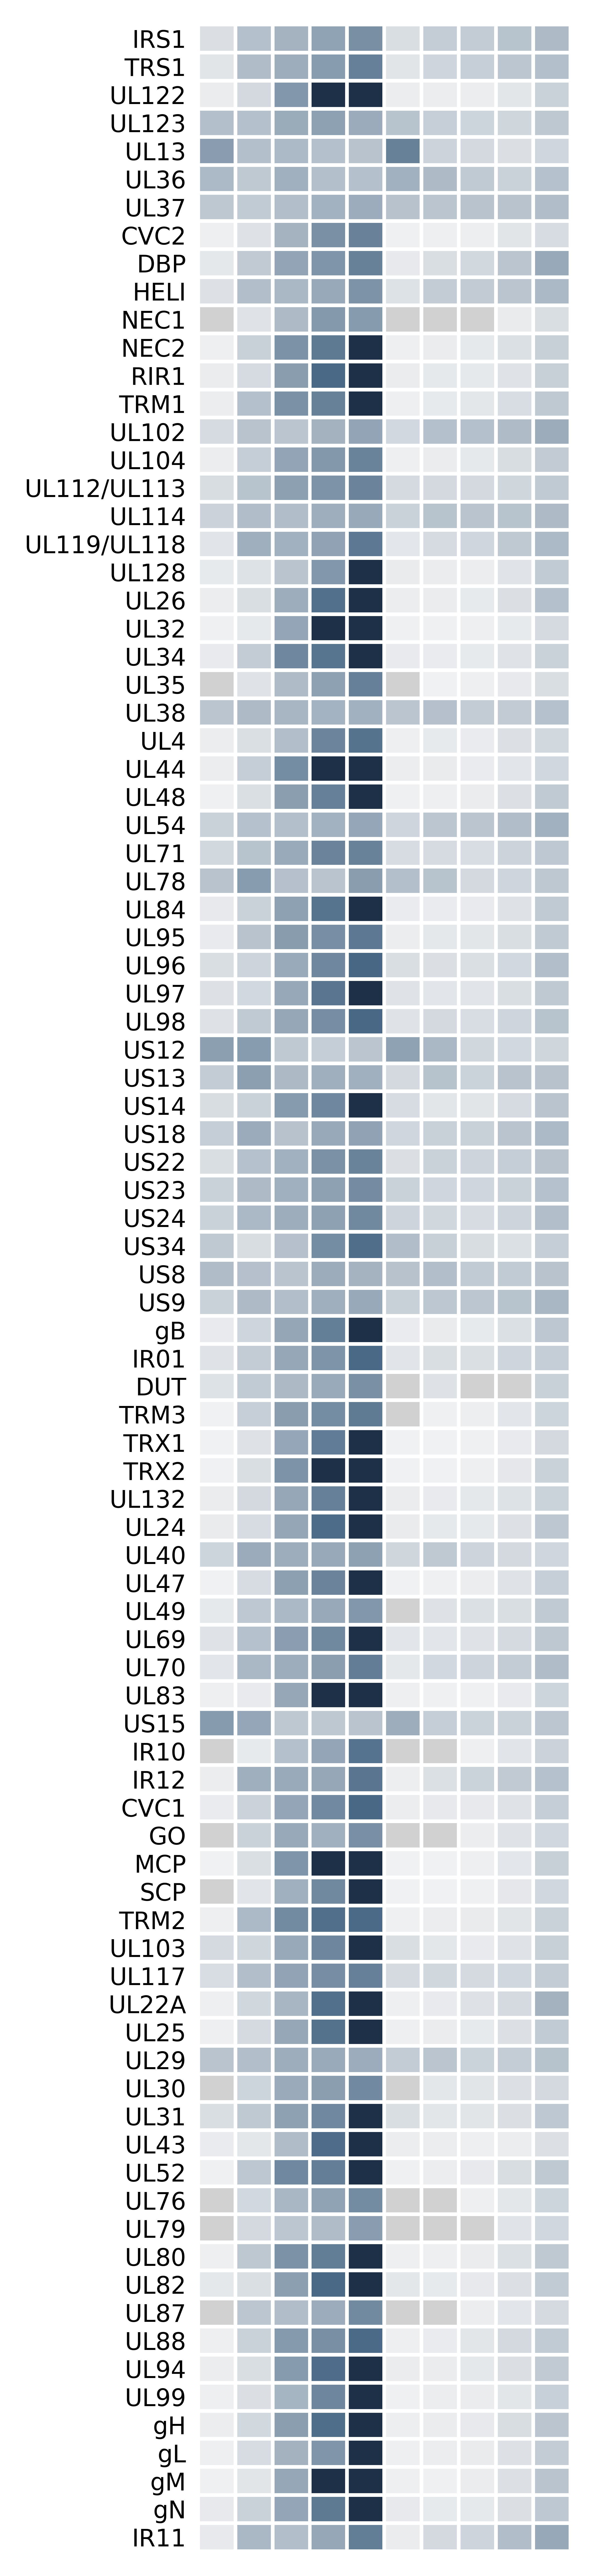

In [9]:
fig, ax = plt.subplots(figsize = (2.5, 10.55), dpi=1000)

data = pd.concat([hcmv_all_mean.unstack(['treatment', 'timepoint'])[hcmv_all_mean.unstack(['treatment', 'timepoint']).index.get_level_values('temporality')==t] for t in ['IE', 'DE', 'LL', 'L']])[['DMSO', 'CAY10602']]
idx = data.index.names
data=data.reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
data = data.set_index(idx)

cm = sns.light_palette((71/256, 103/256, 133/256), reverse=False, as_cmap=True)
cm.set_over((30/256, 48/256, 72/256))
cm.set_under((210/256, 210/256, 210/256))

sns.heatmap(data.fillna(-1), 
            cmap=cm, 
            ax=ax, 
            vmax=data.melt()['value'].describe(percentiles=[.95])['95%'], 
            vmin=0,
            linewidth=1,
            cbar=False
           )

print(data.melt()['value'].describe(percentiles=[.95])['95%'],)
ax.tick_params(axis='y', size=0)
ax.set_yticks(np.linspace(0.5, ax.get_ylim()[0]-0.5, int(ax.get_ylim()[0])))

yticklabels = data.index.get_level_values('Protein Gene')#(hcmv_all_norm.unstack('treatment').groupby(data.index.names+['timepoint']).apply(TTEST).squeeze()<=0.05).unstack().all(axis=1).reindex(data.index).where(lambda x: x==False, '*').where(lambda x: x!=False, '').str.cat(data.index.get_level_values('Protein Gene'), sep=' ')
ax.set_yticklabels(yticklabels, fontsize=7)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('')

fig.tight_layout()
fig.savefig(r'..\figures\Fig5A.svg', bbox_inches='tight')
plt.show()

### Fig. 5B

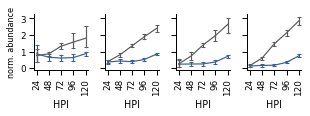

In [25]:
fig, axs = plt.subplots(ncols=4, figsize = (4.4, 1.6), sharey=True)

for ax, t in zip(axs, ['IE', 'DE', 'LL', 'L']):
    data = hcmv_all_mean[(hcmv_all_mean.index.get_level_values('temporality')==t)]
    sns.lineplot(data=data.reset_index(), x='timepoint', y=0, 
                 hue='treatment', 
                 hue_order = ['CAY10602', 'DMSO'],
                 palette = [bright_pal[1], pal[-1]], ax=ax,
                 err_style='bars', err_kws = {'capsize': 2}
                )
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([0, 1, 2, 3])
    ax.set_xticks([24, 48, 72, 96, 120])
    ax.set_ylabel('')
    ax.set_xlabel('HPI')
    ax.set_xticklabels([24, 48, 72, 96, 120], rotation=90)

#     annots = add_stars(data.unstack('treatment').groupby('timepoint').apply(TTEST).squeeze())
#     y = data.unstack('treatment')['DMSO'].groupby('timepoint').apply(lambda x: sns.utils.ci(sns.algorithms.bootstrap(x))[1])

#     for (x, y_), s in zip(y.iteritems(), annots):
#         ax.text(x, y_+0.1, s, ha='center', fontsize=6.5)
            
axs[0].set_ylabel('norm. abundance', fontsize=8)
fig.tight_layout()       
fig.savefig(r'..\figures\Fig5B.png', dpi=1000, bbox_inches='tight')

plt.show()

### Fig. 5C

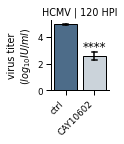

In [24]:
fig, ax = plt.subplots(figsize = (1.7, 2.1))

data=np.log10(sirt_titers.sort_index()[['control', 'CAY10602']])
sns.barplot(data=data.reset_index(), 
            x='treatment', y='IU/ml', 
            ax=ax,
            palette=hcmv_palette([10, 200]), 
            capsize=0.2, errwidth=1.5, saturation=1,
            linewidth=1, edgecolor='k', errcolor='k'
            )
ax.set_ylabel('virus titer\n($log_{10}IU/ml$)')
ax.text(1, data.unstack('treatment')['CAY10602'].mean()+0.5, add_stars(TTEST(data.unstack('treatment'))).values[0], ha='center', fontsize=12)
ax.set_title('HCMV | 120 HPI')

ax.set_xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(['ctrl', 'CAY10602'], rotation = 45, ha='right')
    
fig.tight_layout()
fig.savefig(r'..\figures\Fig5C.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 5D

0 1.7920135587453514


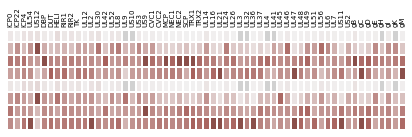

In [11]:
fig, ax = plt.subplots(figsize = (5.83, 2))

cm = sns.light_palette((168/256, 97/256, 92/256), reverse=False, as_cmap=True)
cm.set_over((140/256, 79/256, 74/256))
cm.set_under((210/256, 210/256, 210/256))

data = pd.concat([hsv1_all_mean.unstack(['treatment', 'timepoint'])[hsv1_all_mean.unstack(['treatment', 'timepoint']).index.get_level_values('temporality')==t] for t in ['IE', 'E', 'L']])[['DMSO', 'CAY']]
vmin = 0
vmax = data.melt()['value'].describe(percentiles=[.95])['95%']

sns.heatmap(data.fillna(-1).T, 
            cmap=cm, 
            ax=ax, 
            vmax=vmax, 
            vmin=vmin,
            linewidth=1,
            cbar=False,
            xticklabels = data.index.get_level_values('Protein Gene')
           )

print(vmin, vmax)
ax.xaxis.tick_top()
ax.tick_params(axis='x', size=0)
ax.set_xticklabels(data.index.get_level_values('Protein Gene'), rotation=90, fontsize=7)
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

fig.tight_layout()
fig.savefig(r'..\figures\Fig5D.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 5E

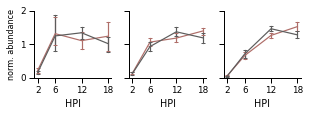

In [26]:
fig, axs = plt.subplots(ncols=3, figsize = (4.4, 1.7), sharey=True)

for ax, t in zip(axs, ['IE', 'E', 'L']):
    data = hsv1_all_mean[(hsv1_all_mean.index.get_level_values('temporality')==t)]
    sns.lineplot(data=data.reset_index(), x='timepoint', y=0, 
                 hue='treatment', 
                 hue_order = ['CAY', 'DMSO'],
                 palette = [bright_pal[0], pal[-1]], ax=ax,
                 err_style='bars', err_kws = {'capsize': 2}
                )
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([0, 1, 2])
    ax.set_ylim(0, 2)
    ax.set_xticks([2, 6, 12, 18])
    ax.set_ylabel('')
    ax.set_xlabel('HPI')

#     annots = add_stars(data.unstack('treatment').groupby('timepoint').apply(TTEST).squeeze())
#     y = data.groupby(['timepoint', 'treatment']).apply(lambda x: sns.utils.ci(sns.algorithms.bootstrap(x))[1]).unstack().max(axis=1)

#     for (x, y_), s in zip(y.iteritems(), annots):
#         ax.text(x, y_+0.1, s, ha='center', fontsize=6.5)
            
axs[0].set_ylabel('norm. abundance', fontsize=8)
fig.tight_layout()       
fig.savefig(r'..\figures\Fig5E.png', dpi=1000, bbox_inches='tight')

plt.show()

### Fig. 5F

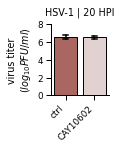

In [18]:
fig, ax = plt.subplots(figsize = (1.7, 2.2))

data=np.log10(titers.loc[['DMSO', 'CAY10602 (12.5uM)'], :].stack([0, 1]))
sns.barplot(data=data.reset_index(), 
            x='sample', y=0, 
            ax=ax,
            palette=hsv1_palette([10, 200]), 
            capsize=0.2, errwidth=1.5, saturation=1,
            linewidth=1, edgecolor='k', errcolor='k'
            )
ax.set_ylabel('virus titer\n($log_{10}PFU/ml$)')
ax.set_title('HSV-1 | 20 HPI', y=1.05)

ax.set_xlabel('')
ax.set_yticks([0, 2, 4, 6, 8])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(['ctrl', 'CAY10602'], rotation = 45, ha='right')
    
fig.tight_layout()
fig.savefig(r'..\figures\Fig5F.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 5G

0 1.8689675878757674


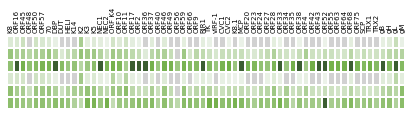

In [13]:
fig, ax = plt.subplots(figsize = (5.83, 1.7))

cm = sns.light_palette((113/256, 175/256, 71/256), reverse=False, as_cmap=True)
cm.set_over((59/256, 94/256, 49/256))
cm.set_under((210/256, 210/256, 210/256))

data = pd.concat([kshv_all_mean.unstack(['treatment', 'timepoint'])[kshv_all_mean.unstack(['treatment', 'timepoint']).index.get_level_values('temporality')==t] for t in ['IE', 'DE', 'L']])[['DMSO', 'CAY']]
vmin = 0
vmax = data.melt()['value'].describe(percentiles=[.95])['95%']

sns.heatmap(data.fillna(-1).T, 
            cmap=cm, 
            ax=ax, 
            vmax=vmax, 
            vmin=vmin,
            linewidth=1,
            cbar=False,
            xticklabels = data.index.get_level_values('Protein Gene')
           )

print(vmin, vmax)
ax.xaxis.tick_top()
ax.tick_params(axis='x', size=0)
ax.set_xticklabels(data.index.get_level_values('Protein Gene'), rotation=90, fontsize=7)
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

fig.tight_layout()
fig.savefig(r'..\figures\Fig5G.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 5H

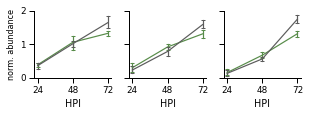

In [27]:
fig, axs = plt.subplots(ncols=3, figsize = (4.4, 1.7), sharey=True)

for ax, t in zip(axs, ['IE', 'DE', 'L']):
    data = kshv_all_mean[(kshv_all_mean.index.get_level_values('temporality')==t)]
    sns.lineplot(data=data.reset_index(), x='timepoint', y=0, 
                 hue='treatment', 
                 hue_order = ['CAY', 'DMSO'],
                 palette = [bright_pal[2], pal[-1]], ax=ax,
                 err_style='bars', err_kws = {'capsize': 2}
                )
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([0, 1, 2])
    ax.set_ylim(0, 2)
    ax.set_xticks([24, 48, 72])
    ax.set_ylabel('')
    ax.set_xlabel('HPI')

#     annots = add_stars(data.unstack('treatment').groupby('timepoint').apply(TTEST).squeeze())
#     y = data.groupby(['timepoint', 'treatment']).apply(lambda x: sns.utils.ci(sns.algorithms.bootstrap(x))[1]).unstack().max(axis=1)

#     for (x, y_), s in zip(y.iteritems(), annots):
#         ax.text(x, y_+0.1, s, ha='center', fontsize=6.5)
            
axs[0].set_ylabel('norm. abundance', fontsize=8)
fig.tight_layout()       
fig.savefig(r'..\figures\Fig5H.png', dpi=1000, bbox_inches='tight')

plt.show()

### Fig. 5I

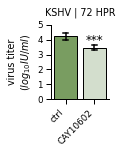

In [20]:
fig, ax = plt.subplots(figsize = (1.7, 2.25))

data=np.log10(kshv_titers['% GFP+']*10**4)
sns.barplot(data=data.reset_index(), 
            x='treatment', y='% GFP+', 
            ax=ax,
            palette=kshv_palette([10, 200]), 
            capsize=0.2, errwidth=1.5, saturation=0.6,
            linewidth=1, edgecolor='k', errcolor='k'
            )

ax.set_title('KSHV | 72 HPR', y=1.05)
ax.set_ylabel('virus titer\n($log_{10}IU/ml$)')

ax.set_xlabel('')
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(['ctrl', 'CAY10602'], rotation = 45, ha='right')

ax.text(1, data.unstack('treatment')['CAY10602'].mean()+0.25, add_stars(TTEST(data.unstack('treatment'))).values[0], ha='center', fontsize=12)

fig.tight_layout()
fig.savefig(r'..\figures\Fig5I.png', dpi=1000, transparent=False, bbox_inches='tight')
plt.show()

### Fig. S6F

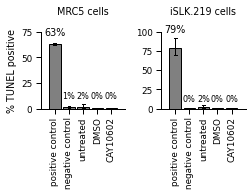

In [30]:
mrc5_samples = ['positive control', 'negative control', 'untreated', 'DMSO', 'CAY10602 (12.5uM)']
islk_samples = ['positive control', 'negative control', 'untreated', 'DMSO', 'CAY10602 (12.5uM)']
n = len(mrc5_samples)+len(islk_samples)

fig, axs = plt.subplots(figsize=(3.6, 3), ncols=2, gridspec_kw={'width_ratios': [len(mrc5_samples)/n, len(islk_samples)/n]})

for ax, cell_type, x_order, offset in zip(axs, ['MRC5', 'iSLK.219'], [mrc5_samples, islk_samples], [8, 20]):
    sns.barplot(
        data=pct_apop[cell_type].reset_index(), 
        x='sample', 
        y='OD', 
        order = x_order,
        ax=ax,
        color='grey',
        capsize=0.2,
        errcolor='black',
        errwidth=1,
        linewidth=1,
        edgecolor='k'
    )
        
    ax.set_xticklabels(['positive control', 'negative control', 'untreated', 'DMSO', 'CAY10602'], rotation=90)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('{} cells'.format(cell_type), y=1.15)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.text(0, pct_apop[cell_type].groupby('sample').mean().max()+offset, '{:.0f}%'.format(pct_apop[cell_type].groupby('sample').mean().max()), ha='center')
    
    for i, x in enumerate(x_order[1:], 1):
        ax.text(i, 10, '{:.0f}%'.format(pct_apop[cell_type].groupby('sample').mean()[x]), ha='center', fontsize=8)
    
    ax.set_xlim(-1, len(x_order))
    
axs[0].set_ylim(0, 75)
axs[0].set_yticks([0, 25, 50, 75])
axs[1].set_ylim(0, 100)
axs[1].set_yticks([0, 25, 50, 75, 100])

axs[0].set_ylabel('% TUNEL positive')
    
fig.tight_layout()
fig.savefig(r'..\figures\FigS6F.png', dpi=1000, bbox_inches='tight')
plt.show()